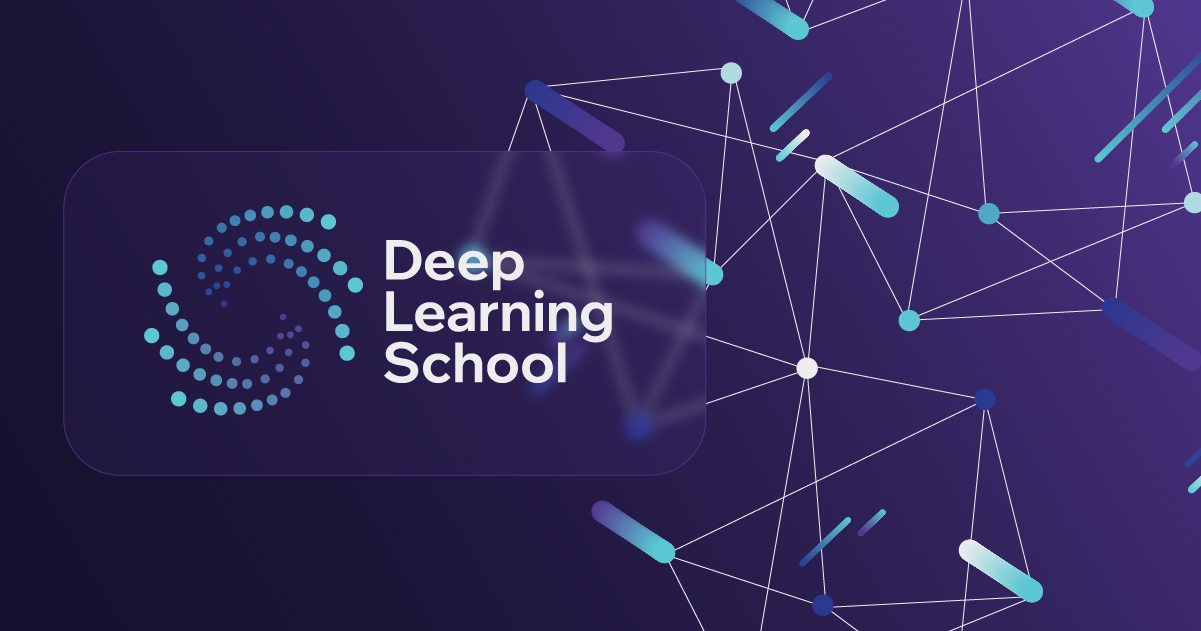


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

In [4]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import tqdm
import imageio
from PIL import Image
import kagglehub

%matplotlib inline

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [2]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Path to dataset files: /kaggle/input/lfw-dataset


In [3]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Path to dataset files: /kaggle/input/lfw-attributes


In [4]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [5]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id,'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    images = images.astype('float32') / 255.0
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [6]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [7]:
# пример как можно было сделать(чисто для себя)
'''
path = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])
dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
'''

'\npath = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.5, 0.5, 0.5],\n                         std=[0.5, 0.5, 0.5])\n])\ndataset = datasets.ImageFolder(root=path, transform=transform)\ndataloader = DataLoader(dataset, batch_size=32, shuffle=True)\n'

In [8]:
train_im, val_im = train_test_split(images, test_size=0.8, shuffle=False)
train_attrs, val_attrs = train_test_split(attrs, test_size=0.8, shuffle=False)

tensor_train = torch.tensor(train_im).permute(0, 3, 1, 2)
tensor_val = torch.tensor(val_im).permute(0, 3, 1, 2)

data_load_train_im = torch.utils.data.DataLoader(tensor_train, batch_size=32)
data_load_val_im = torch.utils.data.DataLoader(tensor_val, batch_size=32)

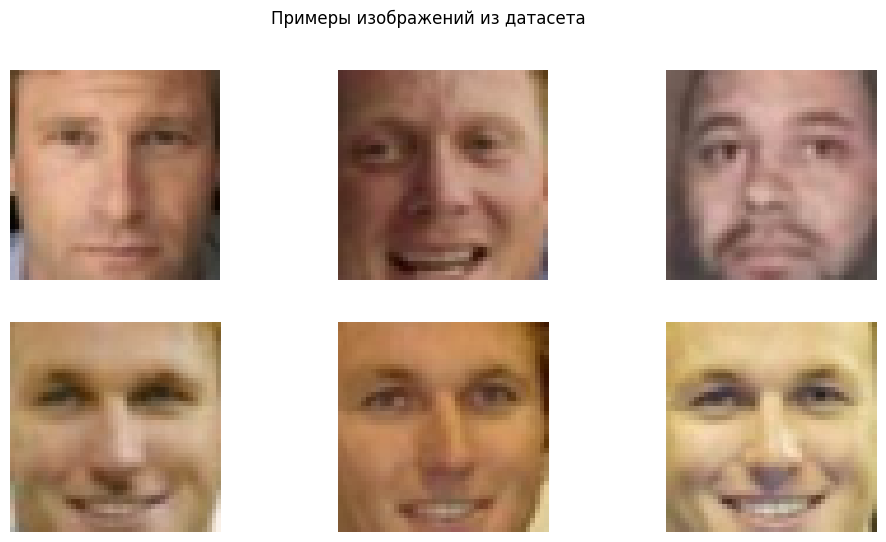

In [9]:
import matplotlib.pyplot as plt

images_to_show = tensor_train[:6]
images_to_show = images_to_show.permute(0, 2, 3, 1).numpy()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images_to_show[i])
    plt.axis('off')
plt.suptitle("Примеры изображений из датасета")
plt.show()


## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



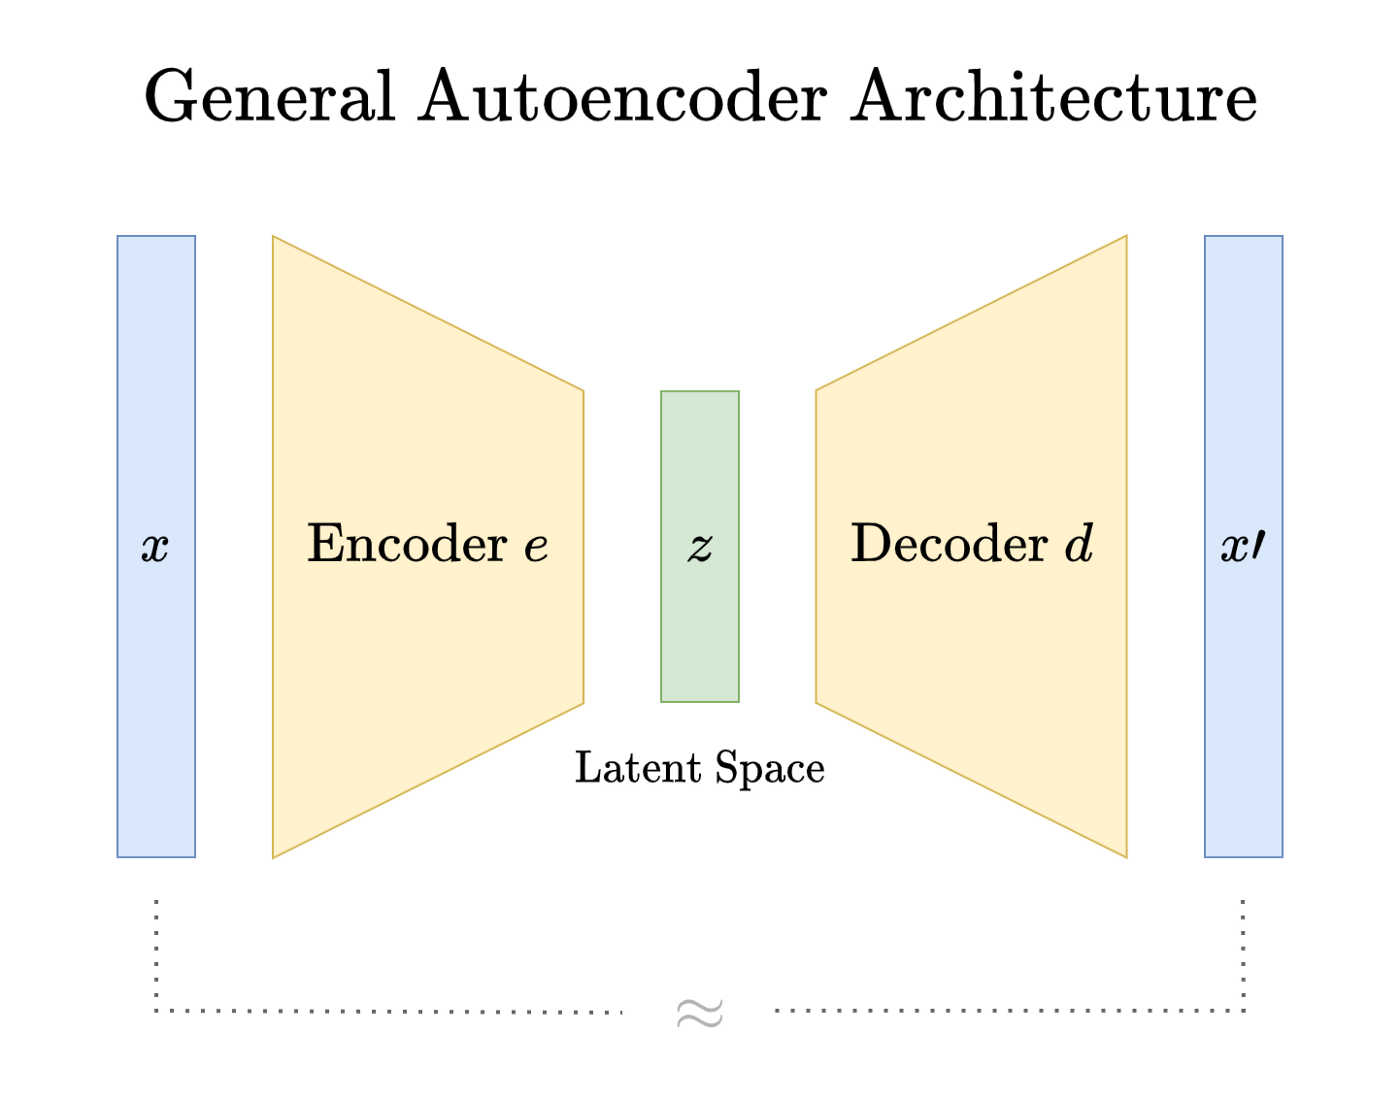

In [10]:
dim_code = 16

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(6075, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 6075),
            nn.Tanh()
        )

    def forward(self, x):

        x_flatt = self.flatten(x)
        latent_code = self.encoder(x_flatt)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
criterion = nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

cpu


## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

  0%|          | 0/30 [00:00<?, ?it/s]

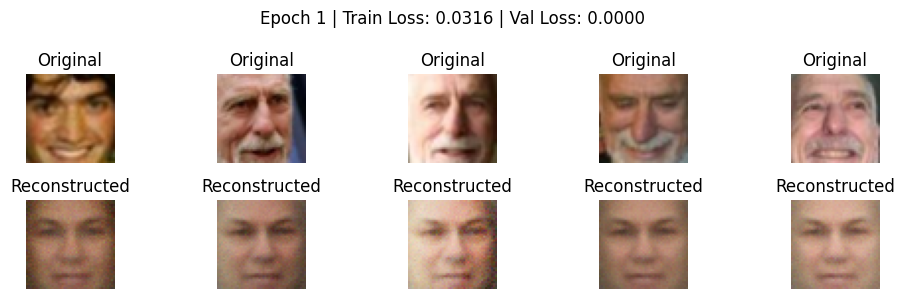

  3%|▎         | 1/30 [00:20<10:01, 20.76s/it]

Epoch 1/30 | Train Loss: 0.0316 | Val Loss: 0.0166


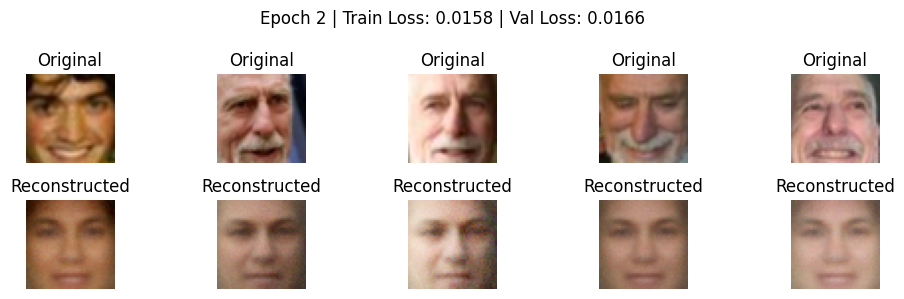

  7%|▋         | 2/30 [00:40<09:17, 19.90s/it]

Epoch 2/30 | Train Loss: 0.0158 | Val Loss: 0.0133


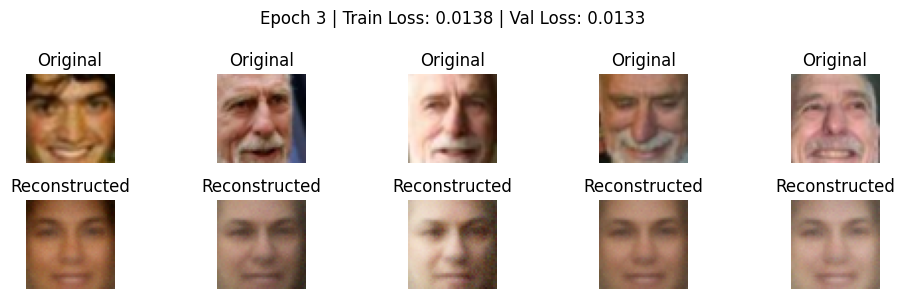

 10%|█         | 3/30 [01:00<09:01, 20.06s/it]

Epoch 3/30 | Train Loss: 0.0138 | Val Loss: 0.0126


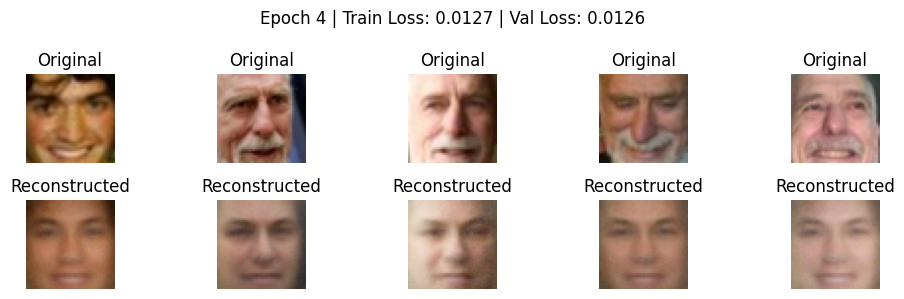

 13%|█▎        | 4/30 [01:19<08:35, 19.83s/it]

Epoch 4/30 | Train Loss: 0.0127 | Val Loss: 0.0122


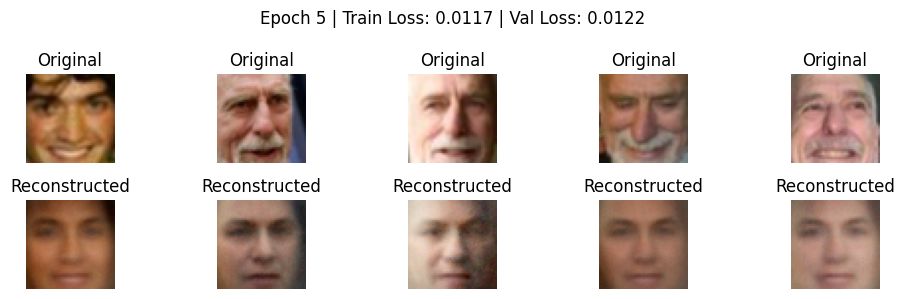

 17%|█▋        | 5/30 [01:39<08:19, 19.97s/it]

Epoch 5/30 | Train Loss: 0.0117 | Val Loss: 0.0131


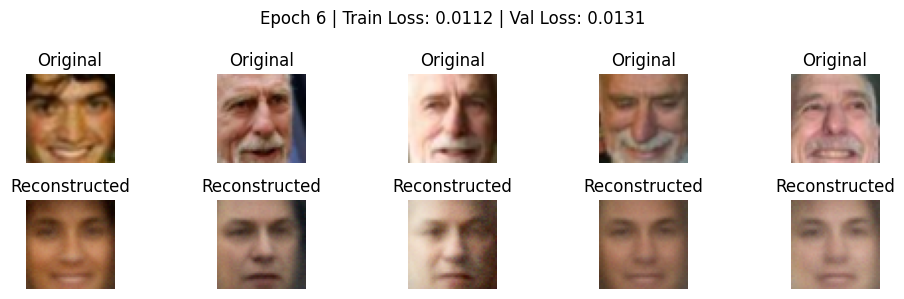

 20%|██        | 6/30 [01:59<07:52, 19.68s/it]

Epoch 6/30 | Train Loss: 0.0112 | Val Loss: 0.0107


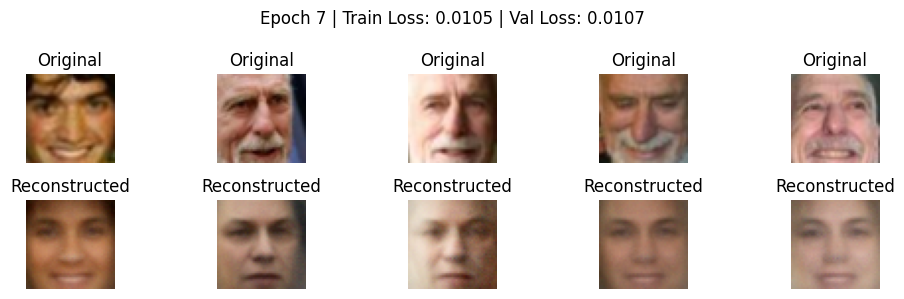

 23%|██▎       | 7/30 [02:19<07:36, 19.85s/it]

Epoch 7/30 | Train Loss: 0.0105 | Val Loss: 0.0100


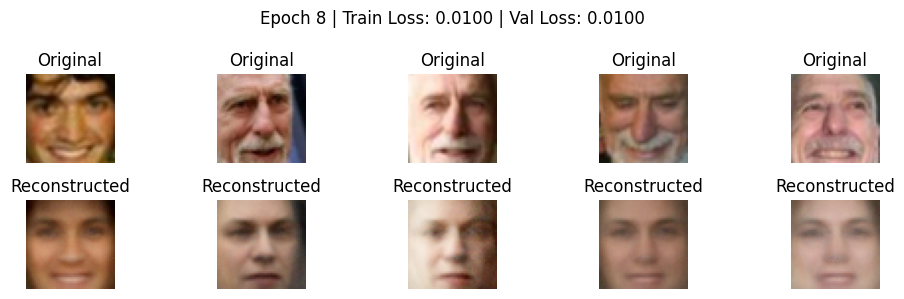

 27%|██▋       | 8/30 [02:43<07:47, 21.24s/it]

Epoch 8/30 | Train Loss: 0.0100 | Val Loss: 0.0098


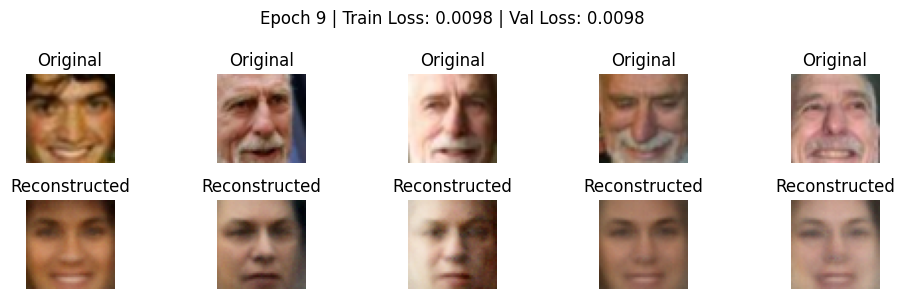

 30%|███       | 9/30 [03:17<08:49, 25.20s/it]

Epoch 9/30 | Train Loss: 0.0098 | Val Loss: 0.0097


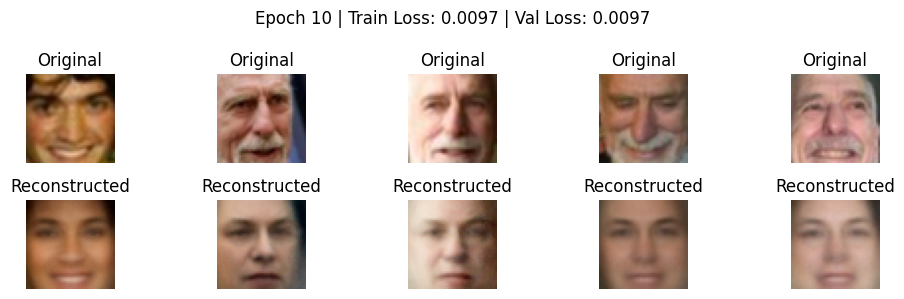

 33%|███▎      | 10/30 [03:53<09:28, 28.42s/it]

Epoch 10/30 | Train Loss: 0.0097 | Val Loss: 0.0092


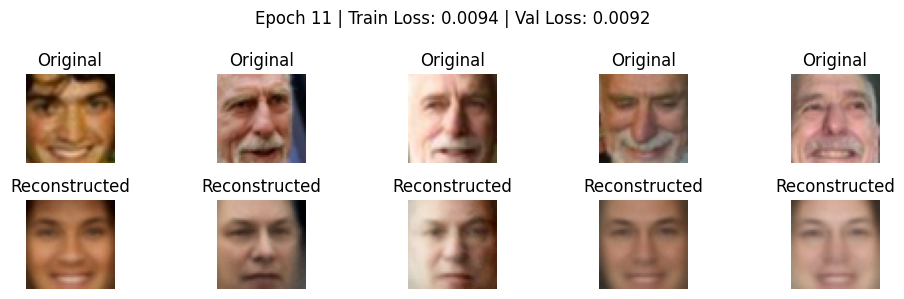

 37%|███▋      | 11/30 [04:26<09:30, 30.04s/it]

Epoch 11/30 | Train Loss: 0.0094 | Val Loss: 0.0091


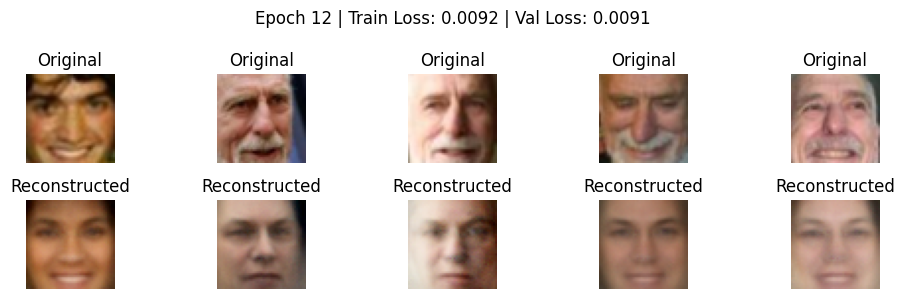

 40%|████      | 12/30 [05:02<09:30, 31.72s/it]

Epoch 12/30 | Train Loss: 0.0092 | Val Loss: 0.0089


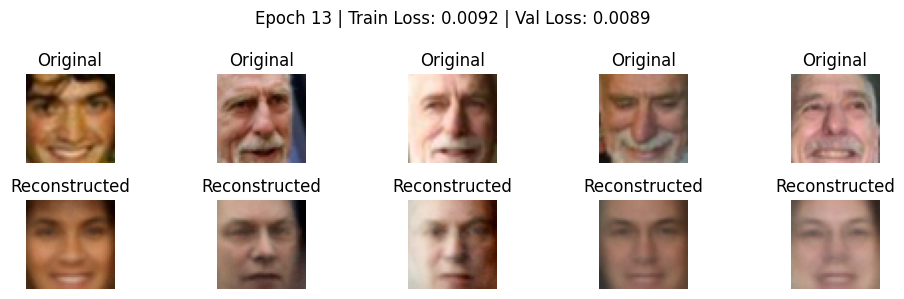

 43%|████▎     | 13/30 [05:35<09:06, 32.17s/it]

Epoch 13/30 | Train Loss: 0.0092 | Val Loss: 0.0095


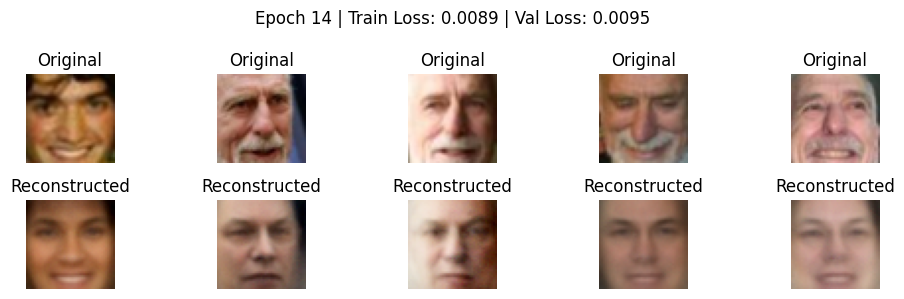

 47%|████▋     | 14/30 [06:09<08:42, 32.64s/it]

Epoch 14/30 | Train Loss: 0.0089 | Val Loss: 0.0087


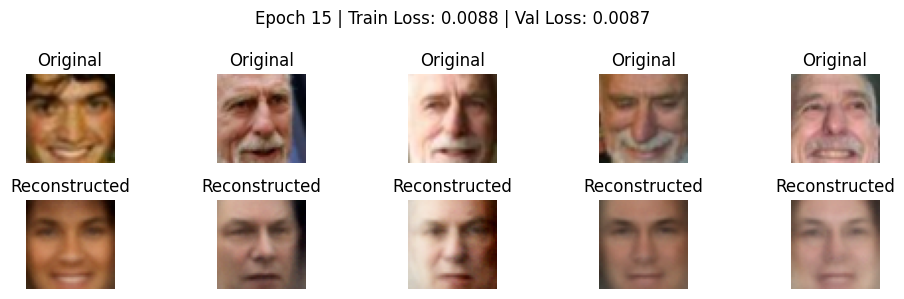

 50%|█████     | 15/30 [06:48<08:39, 34.63s/it]

Epoch 15/30 | Train Loss: 0.0088 | Val Loss: 0.0088


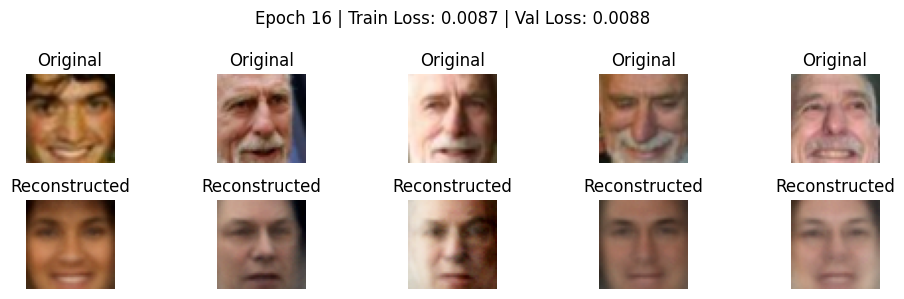

 53%|█████▎    | 16/30 [07:22<08:01, 34.36s/it]

Epoch 16/30 | Train Loss: 0.0087 | Val Loss: 0.0111


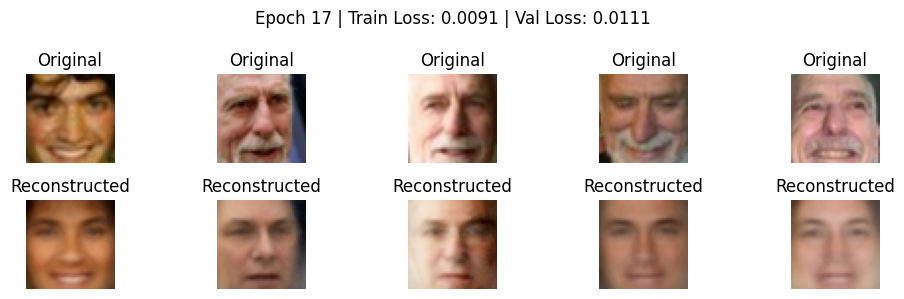

 57%|█████▋    | 17/30 [07:54<07:18, 33.76s/it]

Epoch 17/30 | Train Loss: 0.0091 | Val Loss: 0.0087


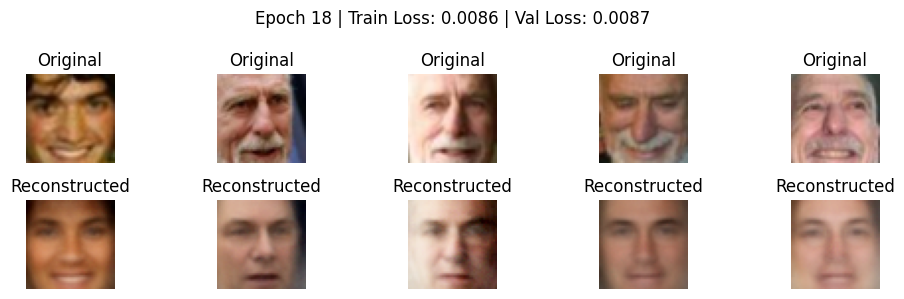

 60%|██████    | 18/30 [08:30<06:51, 34.31s/it]

Epoch 18/30 | Train Loss: 0.0086 | Val Loss: 0.0087


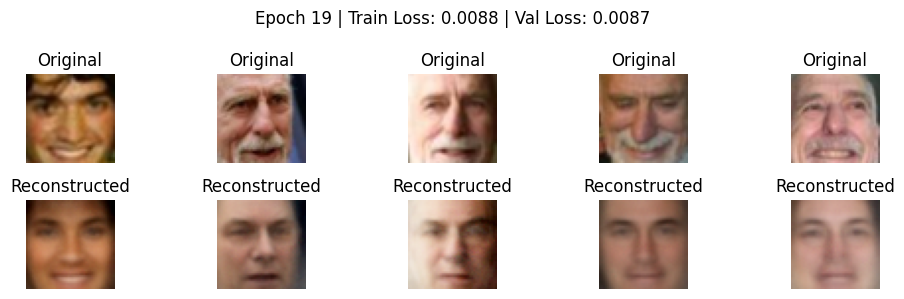

 63%|██████▎   | 19/30 [09:03<06:13, 33.98s/it]

Epoch 19/30 | Train Loss: 0.0088 | Val Loss: 0.0083


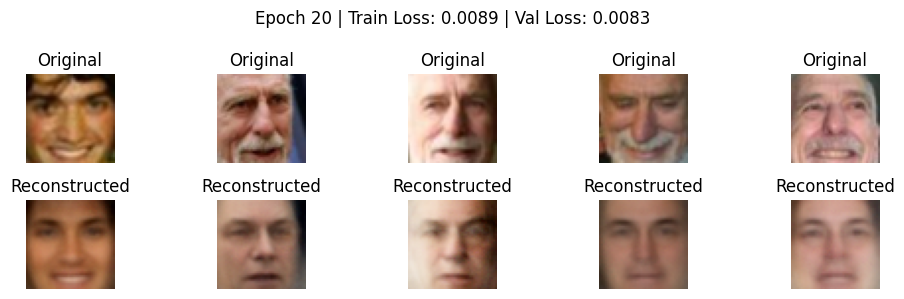

 67%|██████▋   | 20/30 [09:35<05:34, 33.47s/it]

Epoch 20/30 | Train Loss: 0.0089 | Val Loss: 0.0088


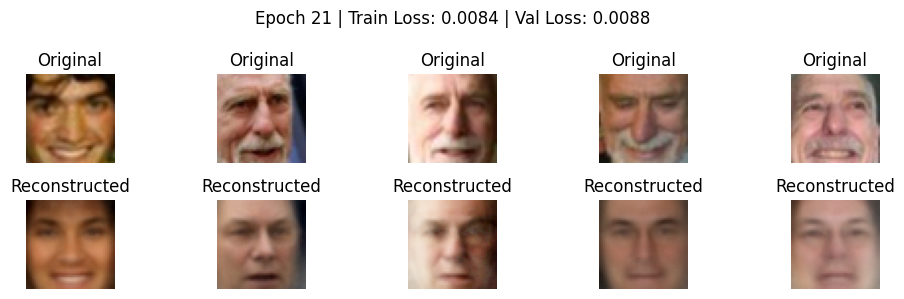

 70%|███████   | 21/30 [10:09<05:00, 33.43s/it]

Epoch 21/30 | Train Loss: 0.0084 | Val Loss: 0.0092


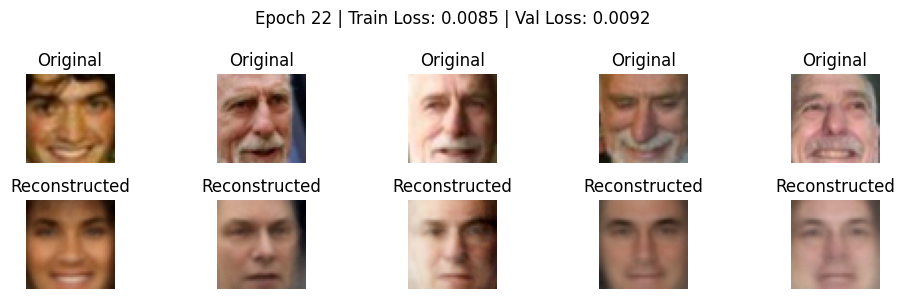

 73%|███████▎  | 22/30 [10:42<04:26, 33.35s/it]

Epoch 22/30 | Train Loss: 0.0085 | Val Loss: 0.0081


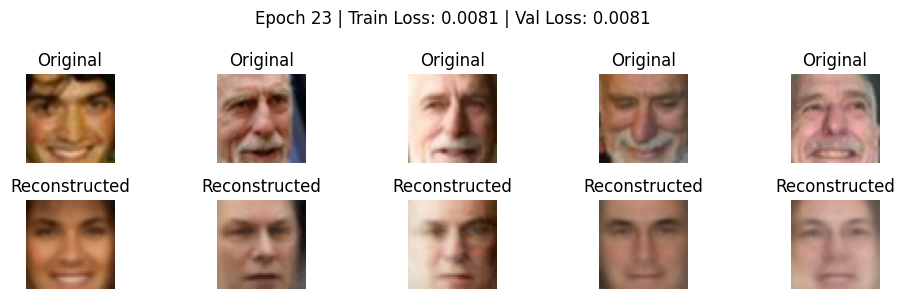

 77%|███████▋  | 23/30 [11:15<03:53, 33.42s/it]

Epoch 23/30 | Train Loss: 0.0081 | Val Loss: 0.0082


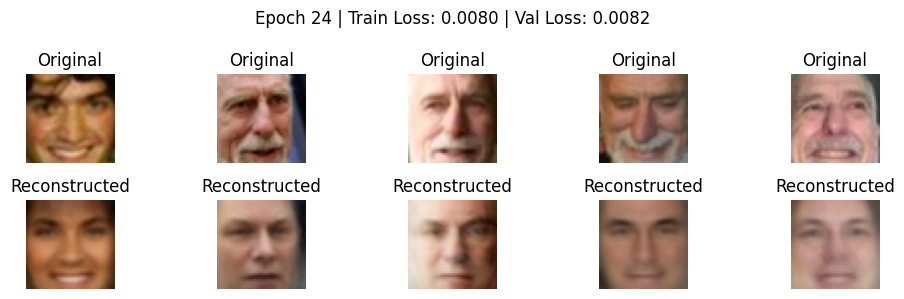

 80%|████████  | 24/30 [11:49<03:20, 33.47s/it]

Epoch 24/30 | Train Loss: 0.0080 | Val Loss: 0.0080


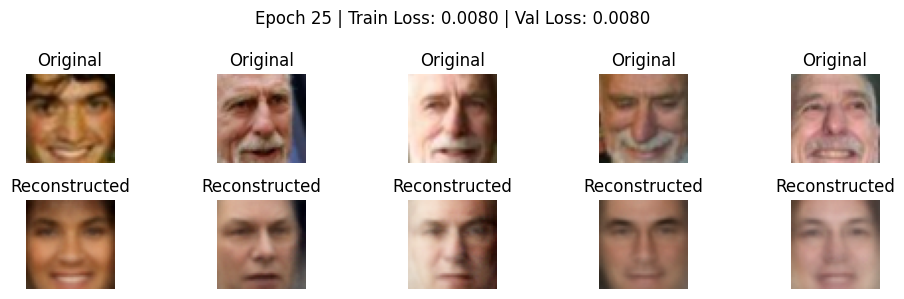

 83%|████████▎ | 25/30 [12:21<02:45, 33.16s/it]

Epoch 25/30 | Train Loss: 0.0080 | Val Loss: 0.0079


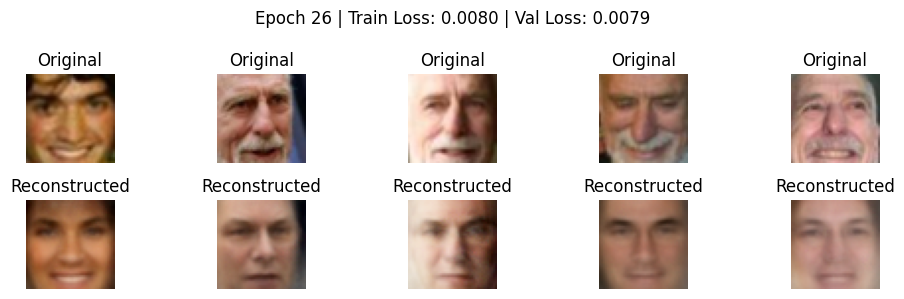

 87%|████████▋ | 26/30 [12:55<02:13, 33.26s/it]

Epoch 26/30 | Train Loss: 0.0080 | Val Loss: 0.0080


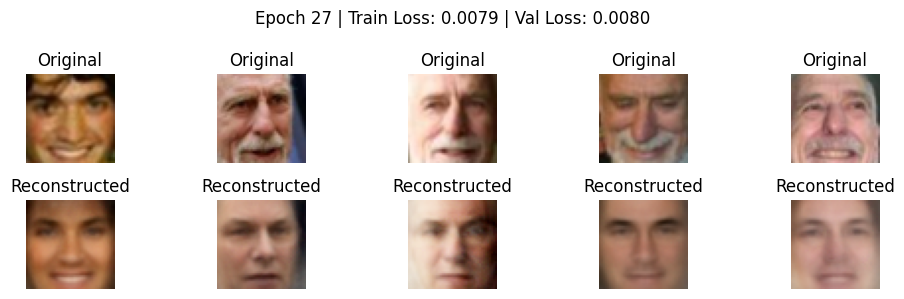

 90%|█████████ | 27/30 [13:28<01:39, 33.18s/it]

Epoch 27/30 | Train Loss: 0.0079 | Val Loss: 0.0079


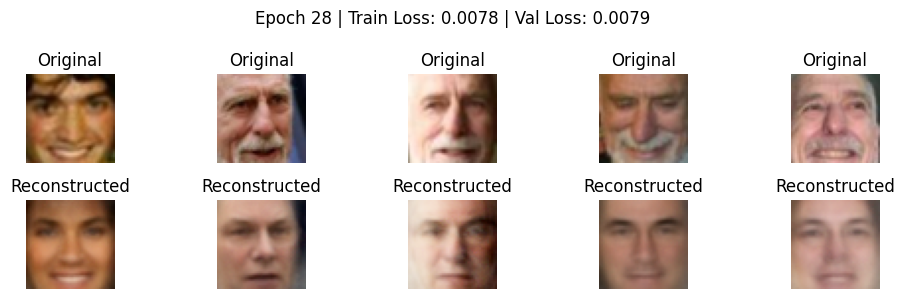

 93%|█████████▎| 28/30 [14:01<01:06, 33.25s/it]

Epoch 28/30 | Train Loss: 0.0078 | Val Loss: 0.0081


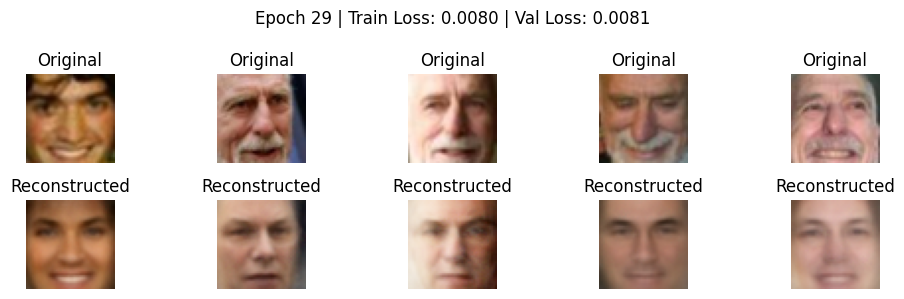

 97%|█████████▋| 29/30 [14:34<00:33, 33.24s/it]

Epoch 29/30 | Train Loss: 0.0080 | Val Loss: 0.0089


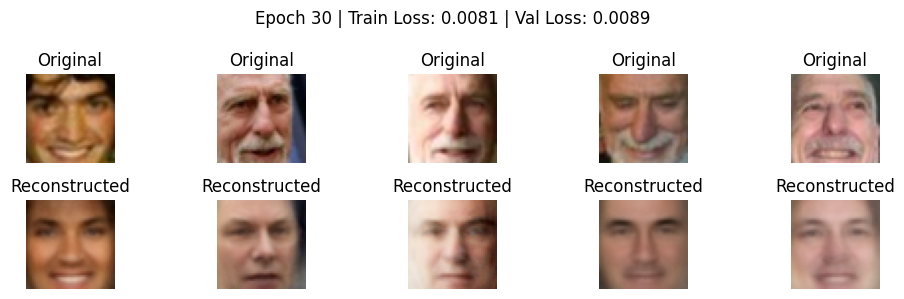

100%|██████████| 30/30 [15:08<00:00, 30.29s/it]

Epoch 30/30 | Train Loss: 0.0081 | Val Loss: 0.0087


In [13]:
import torch
from tqdm import tqdm

n_epochs = 30
train_losses = []
val_losses = []

autoencoder = autoencoder.to(device)
val_loss_mean = 0
with torch.no_grad():
    for batch in data_load_val_im:
        fixed_batch = batch[:5].to(device).float()
        break

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []

    for batch in data_load_train_im:
        batch = batch.to(device).float()

        optimizer.zero_grad()
        reconstruction, latent_code = autoencoder(batch)

        loss = criterion(reconstruction, batch.view(batch.size(0), -1))
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())
    train_loss_mean = sum(train_losses_per_epoch) / len(train_losses_per_epoch)
    train_losses.append(train_loss_mean)

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in data_load_val_im:
            batch = batch.to(device).float()
            reconstruction, _ = autoencoder(batch)
            val_loss = criterion(reconstruction, batch.view(batch.size(0), -1))
            val_losses_per_epoch.append(val_loss.item())
    with torch.no_grad():
        reconstruction, _ = autoencoder(fixed_batch)
        reconstruction = reconstruction.view(-1, 3, 45, 45).cpu()
        fixed_batch_cpu = fixed_batch.cpu()


        plt.figure(figsize=(10, 3))
        for i in range(5):

            plt.subplot(2, 5, i + 1)
            plt.imshow(fixed_batch_cpu[i].permute(1, 2, 0))
            plt.title("Original")
            plt.axis("off")

            plt.subplot(2, 5, i + 6)
            plt.imshow(reconstruction[i].permute(1, 2, 0))
            plt.title(f"Reconstructed")
            plt.axis("off")
        plt.suptitle(f"Epoch {epoch+1} | Train Loss: {train_loss_mean:.4f} | Val Loss: {val_loss_mean:.4f}")
        plt.tight_layout()
        plt.show()
    val_loss_mean = sum(val_losses_per_epoch) / len(val_losses_per_epoch)
    val_losses.append(val_loss_mean)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss_mean:.4f} | Val Loss: {val_loss_mean:.4f}")


Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

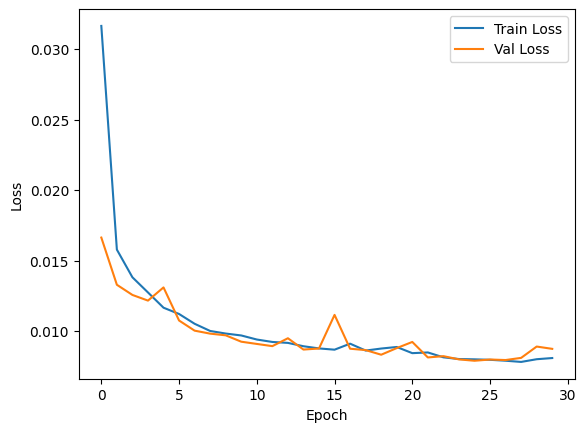

In [17]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

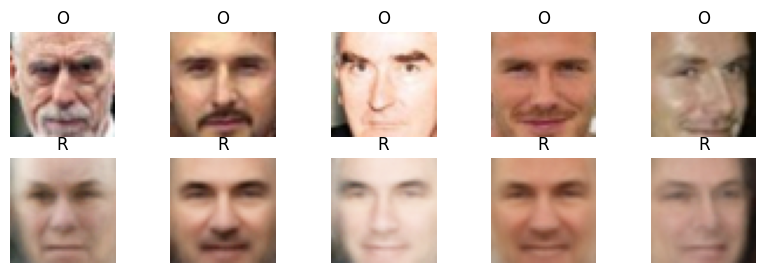

In [18]:
import matplotlib.pyplot as plt

autoencoder.eval()
with torch.no_grad():
    for batch in data_load_val_im:
        batch = batch.to(device).float()
        reconstruction, _ = autoencoder(batch)
        reconstruction = reconstruction.view(-1, 3, 45, 45).cpu()
        batch = batch.cpu()
        plt.figure(figsize=(10, 3))
        for i in range(5, 10):
            plt.subplot(2, 5, i+1-5)
            plt.imshow(batch[i].permute(1, 2, 0))
            plt.title("O")
            plt.axis("off")
            plt.subplot(2, 5, i+6-5)
            plt.imshow(reconstruction[i].permute(1, 2, 0))
            plt.title("R")
            plt.axis("off")
        plt.show()
        break

Что вы можете сказать про результат?

Не нравится, довольно мыльно, но особо лучше сделать не могу, в целом какие-то очертания есть и уже хорошо, если есть предложения по улучшению буду рад

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

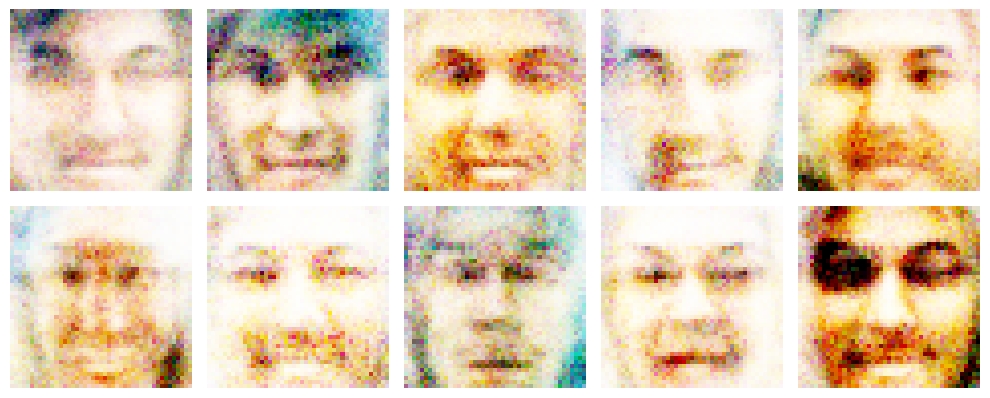

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

latent_space_dim = 128

num_images = 10

z = np.random.randn(num_images, latent_space_dim)

z_tensor = torch.tensor(z, dtype=torch.float32).to(device)

with torch.no_grad():
    autoencoder.eval()
    generated_images = autoencoder.decoder(z_tensor)

generated_images = generated_images.view(num_images, 3, 45, 45).cpu()

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(generated_images[i].permute(1, 2, 0))
    plt.axis("off")
plt.tight_layout()
plt.show()


## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

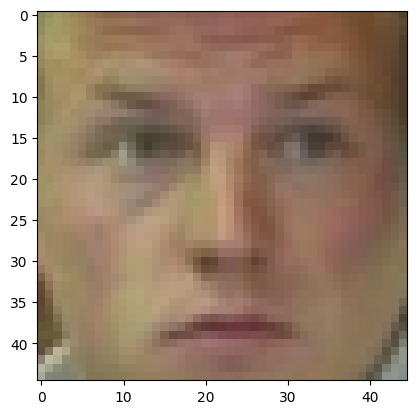

In [67]:
attrs = attrs.sort_values(by='Smiling')
not_smile = [i for i in attrs.index[:15]]
smile = [i for i in attrs.index[-15:]]
plt.imshow(images[not_smile[2]])

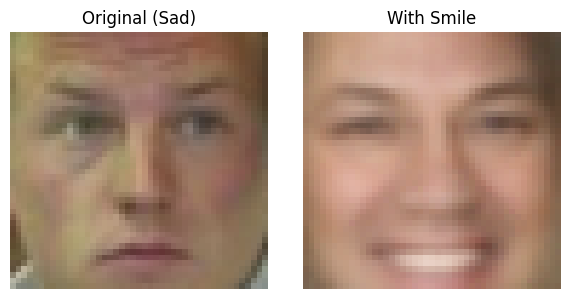

In [66]:
smile_tensor = torch.tensor(images[smile]).permute(0, 3, 1, 2).float().to(device)
not_smile_tensor = torch.tensor(images[not_smile]).permute(0, 3, 1, 2).float().to(device)


autoencoder.eval()
with torch.no_grad():
    _, smile_latents = autoencoder(smile_tensor)
    _, not_smile_latents = autoencoder(not_smile_tensor)


smile_vector = smile_latents.mean(dim=0)
not_smile_vector = not_smile_latents.mean(dim=0)
smile_direction = smile_vector - not_smile_vector


sad_image = images[not_smile[2]]
sad_tensor = torch.tensor(sad_image).permute(2, 0, 1).unsqueeze(0).float().to(device)


with torch.no_grad():
    _, sad_latent = autoencoder(sad_tensor)


smiling_latent = sad_latent + smile_direction.unsqueeze(0)

with torch.no_grad():
    smiling_reconstruction = autoencoder.decoder(smiling_latent)
    smiling_image = smiling_reconstruction.view(-1, 3, 45, 45).cpu().clamp(0, 1)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(sad_image)
plt.title("Original (Sad)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(smiling_image.squeeze().permute(1, 2, 0))
plt.title("With Smile")
plt.axis("off")

plt.tight_layout()
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [3]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:10<00:00, 903kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.98MB/s]


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        '''
        определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma
        '''
        # Encoder
        super(VAE, self).__init__()
        self.encoder_fc = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logsigma = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)


    def encode(self, x):
        '''
        реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma
        '''
        h = F.relu(self.encoder_fc(x))
        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        '''
        реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction
        '''
        h = F.relu(self.decoder_fc1(z))
        reconstruction = torch.sigmoid(self.decoder_fc2(h))
        return reconstruction

    def forward(self, x):
        '''
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        '''
        x = x.view(x.size(0), -1)  # раскладка изображения 28x28 -> вектор 784
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [16]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - torch.exp(2 * logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    kl_loss = KL_divergence(mu, logsigma)
    recon_loss = log_likelihood(x, reconstruction)
    return kl_loss + recon_loss

И обучим модель:

In [14]:
criterion = loss_vae
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = VAE().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
num_epochs = 10
print(device)

cuda


In [15]:
for epoch in range(1, num_epochs + 1):
    autoencoder.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(data)
        loss = criterion(data.view(data.size(0), -1), mu, logsigma, reconstruction)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')

    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            mu, logsigma, reconstruction = autoencoder(data)
            test_loss += criterion(data.view(data.size(0), -1), mu, logsigma, reconstruction).item()
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')

====> Epoch: 1 Average loss: 147.8970
====> Test set loss: 116.2323
====> Epoch: 2 Average loss: 128.2904
====> Test set loss: 110.8848
====> Epoch: 3 Average loss: 125.3601
====> Test set loss: 108.5896
====> Epoch: 4 Average loss: 123.9618
====> Test set loss: 107.7878
====> Epoch: 5 Average loss: 123.1502
====> Test set loss: 107.3794
====> Epoch: 6 Average loss: 122.4962
====> Test set loss: 106.6259
====> Epoch: 7 Average loss: 121.9198
====> Test set loss: 106.0695
====> Epoch: 8 Average loss: 121.4652
====> Test set loss: 106.2136
====> Epoch: 9 Average loss: 121.0920
====> Test set loss: 105.9561
====> Epoch: 10 Average loss: 120.8075
====> Test set loss: 106.4872


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

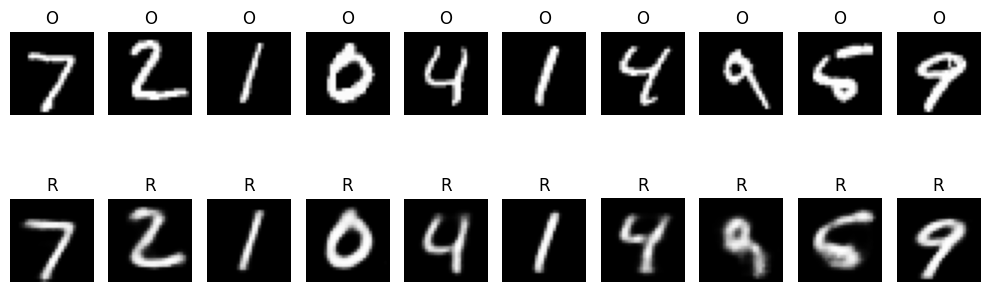

In [17]:
autoencoder.eval()
num_images=10
with torch.no_grad():

    data, _ = next(iter(test_loader))
    data = data.to(device)
    mu, logsigma, reconstruction = autoencoder(data)


    data = data.cpu().view(-1, 28, 28)
    reconstruction = reconstruction.cpu().view(-1, 28, 28)


    plt.figure(figsize=(10, 4))
    for i in range(num_images):

        plt.subplot(2, num_images, i + 1)
        plt.imshow(data[i], cmap='gray')
        plt.title('O')
        plt.axis('off')

        plt.subplot(2, num_images, i + num_images + 1)
        plt.imshow(reconstruction[i], cmap='gray')
        plt.title('R')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

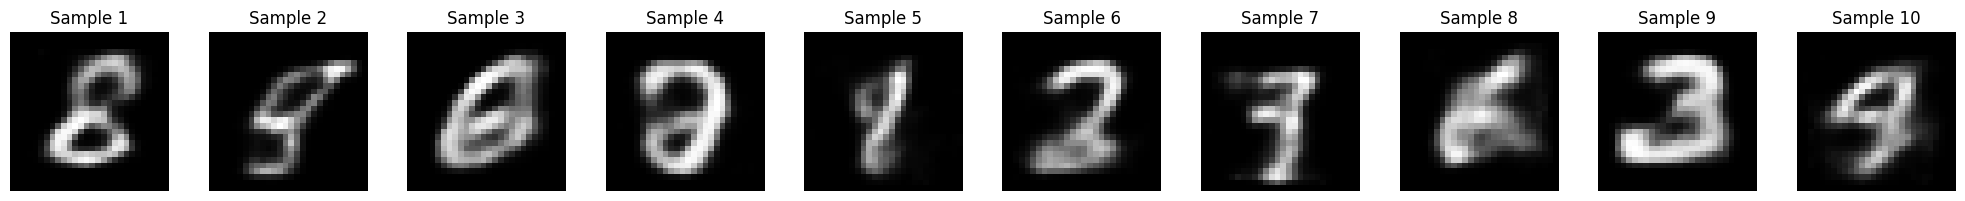

In [21]:
autoencoder.eval()
num_samples=10
with torch.no_grad():

    z = np.array([np.random.normal(0, 1, 20) for _ in range(num_samples)])
    z = torch.tensor(z, dtype=torch.float32).to(device)

    output = autoencoder.decode(z)
    output = output.cpu().view(-1, 28, 28)

    plt.figure(figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(output[i], cmap='gray')
        plt.title(f'Sample {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

Running t-SNE...


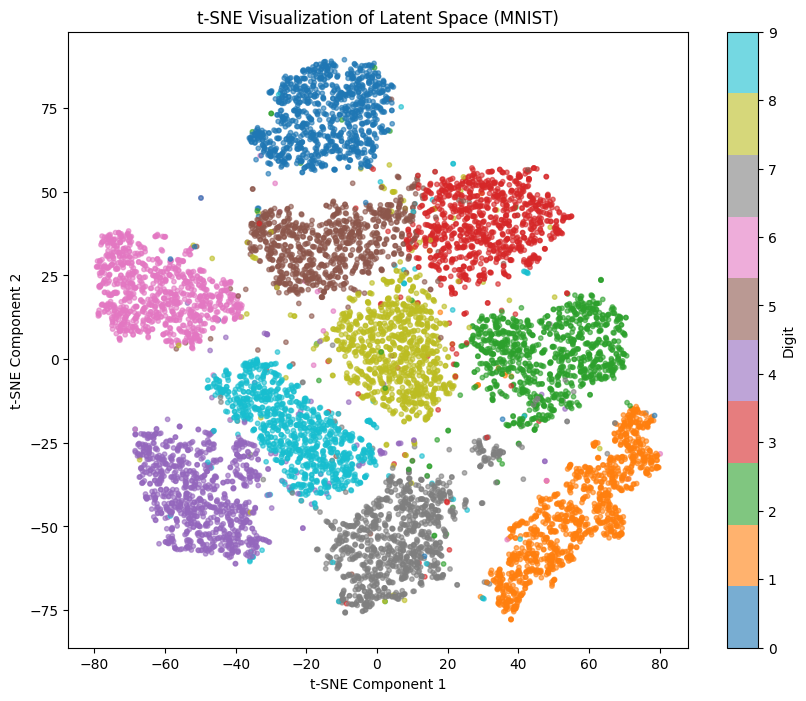

In [23]:
from sklearn.manifold import TSNE
latent_vectors = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        mu, _, _ = autoencoder(data)
        latent_vectors.append(mu.cpu().numpy())
        labels.append(target.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)


print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title('t-SNE Visualization of Latent Space (MNIST)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [14]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, num_classes=10, latent_dim=20, hidden_dim=400):
        super(CVAE, self).__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logsigma = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        # <реализуйте forward проход энкодера
        # в качестве возвращаемых переменных -- mu, logsigma и класс картинки>
        x = torch.cat([x, class_num], dim=1)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)  # sigma = exp(logsigma/2)
            eps = torch.randn_like(std)  # Шум из N(0,1)
            return mu + eps * std
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        # реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction
        z = torch.cat([z, class_num], dim=1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, class_num):
        # используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [29]:
def loss_vae(x, mu, logsigma, reconstruction):
    kl_loss = KL_divergence(mu, logsigma)
    recon_loss = log_likelihood(x, reconstruction)
    return kl_loss + recon_loss

batch_size = 32
input_dim = 784
num_classes = 10
latent_dim = 20
hidden_dim = 400
learning_rate = 1e-3
num_epochs = 10

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE(input_dim=input_dim, num_classes=num_classes, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def to_one_hot(labels, num_classes):
    return F.one_hot(labels, num_classes=num_classes).float()


def train(model, train_loader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        labels_one_hot = to_one_hot(labels, num_classes).to(device)

        optimizer.zero_grad()
        mu, logsigma, reconstruction = model(data, labels_one_hot)
        loss = loss_vae(data, mu, logsigma, reconstruction)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    return train_loss / len(train_loader.dataset)

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(-1, input_dim).to(device)
            labels_one_hot = to_one_hot(labels, num_classes).to(device)

            mu, logsigma, reconstruction = model(data, labels_one_hot)
            loss = loss_vae(data, mu, logsigma, reconstruction)
            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)
    return test_loss


for epoch in range(1, num_epochs + 1):
    print(f'\nEpoch {epoch}/{num_epochs}')
    train_loss = train(model, train_loader, optimizer, device)
    print(f'Average Train Loss: {train_loss:.6f}')
    test_loss = test(model, test_loader, device)


Epoch 1/10
Average Train Loss: 148.181122

Epoch 2/10
Average Train Loss: 123.818623

Epoch 3/10
Average Train Loss: 118.560547

Epoch 4/10
Average Train Loss: 115.875922

Epoch 5/10
Average Train Loss: 114.198692

Epoch 6/10
Average Train Loss: 112.944806

Epoch 7/10
Average Train Loss: 111.961674

Epoch 8/10
Average Train Loss: 111.259192

Epoch 9/10
Average Train Loss: 110.679485

Epoch 10/10
Average Train Loss: 110.233711


Splendid! Вы великолепны!


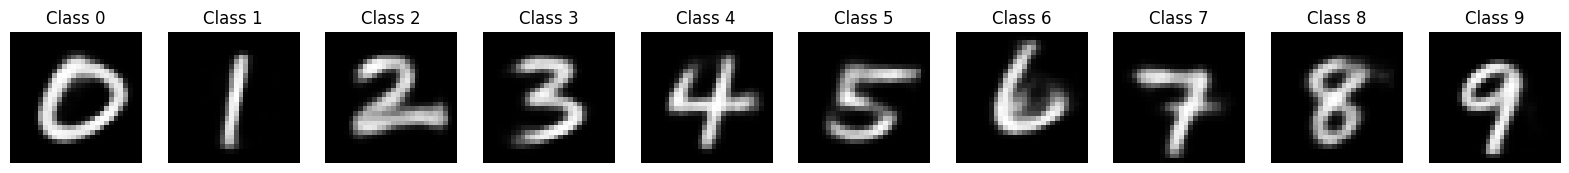

In [28]:
z = torch.randn(1, latent_dim).to(device)
class_labels = [i for i in range(10)]
model.eval()
with torch.no_grad():
    class_one_hot = to_one_hot(torch.tensor(class_labels), num_classes).float().to(device)
    z = z.repeat(len(class_labels), 1)
    reconstructions = model.decode(z, class_one_hot)

fig, axes = plt.subplots(1, len(class_labels), figsize=(len(class_labels) * 2, 2))
for i, img in enumerate(reconstructions):
    img = img.view(28, 28).numpy()
    if len(class_labels) == 1:
        axes.imshow(img, cmap='gray')
        axes.set_title(f'Class {class_labels[i]}')
        axes.axis('off')
    else:
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Class {class_labels[i]}')
        axes[i].axis('off')
plt.show()

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

Text(0, 0.5, 't-SNE Dimension 2')

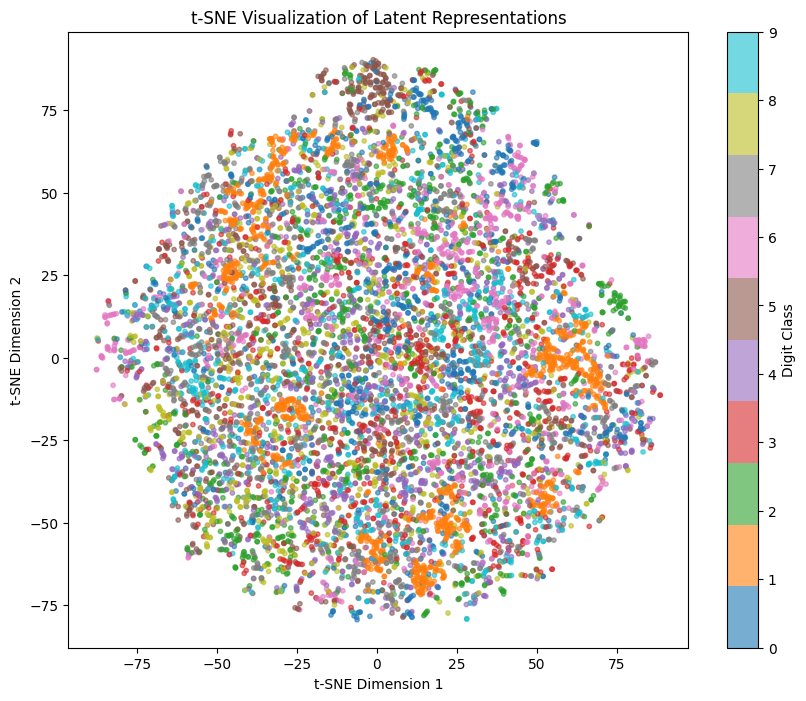

In [33]:
def get_latent_representations(model, test_loader, device, num_classes):
    model.eval()
    latent_mu = []
    labels_list = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(-1, input_dim).to(device)
            labels_one_hot = to_one_hot(labels, num_classes).to(device)

            mu, _, _ = model.encode(data, labels_one_hot)
            latent_mu.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())

    latent_mu = np.concatenate(latent_mu, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    return latent_mu, labels_list

latent_mu, labels = get_latent_representations(model, test_loader, device, num_classes)

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_mu)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.6)
plt.colorbar(scatter, ticks=range(10), label='Digit Class')
plt.title('t-SNE Visualization of Latent Representations')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?
получилось что-то странное -_-